In [58]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.mplot3d import Axes3D

In [63]:
data_folder = '../data/results_SwissRoll/'

isomap_files = np.sort(glob.glob(data_folder + 'Isomap_[0-9][0-9].npy'))
lle_files = np.sort(glob.glob(data_folder + 'LLE_[0-9][0-9].npy'))
ms_files = np.sort(glob.glob(data_folder + 'MS_[0-9][0-9].npy'))
times_files = np.sort(glob.glob(data_folder + '*_time.npy'))

X_2D = np.load('../data/SwissRoll2D/N_2000.npy')
X_2D_scal = minmax_scale(X_2D)

n_neighbors = [20, 28, 40, 57, 80]

In [65]:
times_files

array(['../data/results_SwissRoll/Isomap_time.npy',
       '../data/results_SwissRoll/LLE_time.npy',
       '../data/results_SwissRoll/MS_time.npy'], dtype='<U41')

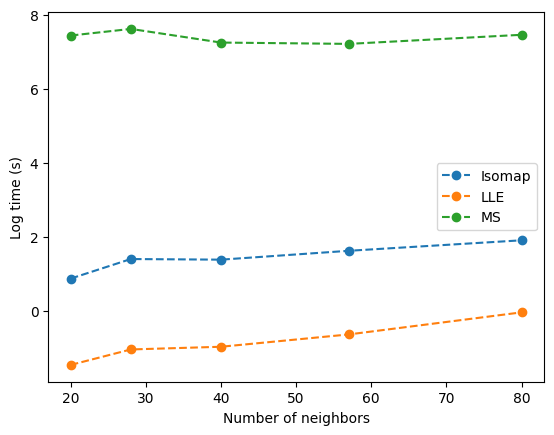

In [73]:
isomap_times = np.loadtxt(times_files[0])
lle_times = np.loadtxt(times_files[1])
ms_times = np.loadtxt(times_files[2])

plt.plot(n_neighbors, np.log(isomap_times), label='Isomap', marker='o', linestyle='--')
plt.plot(n_neighbors, np.log(lle_times), label='LLE', marker='o', linestyle='--')
plt.plot(n_neighbors, np.log(ms_times), label='MS', marker='o', linestyle='--')

plt.xlabel('Number of neighbors')
plt.ylabel('Log time (s)')
plt.legend()

# plt.savefig('../figs/SwissRoll_time.pdf')

In [17]:
i = 1
X_ms = np.loadtxt(ms_files[i])
cov = np.cov(X_ms.T)
eigval,eig = np.linalg.eig(cov)
index = np.argsort(-eigval)
eigvec = np.copy(eig[:,index].astype(np.float32))

X_pca = X_ms@eigvec

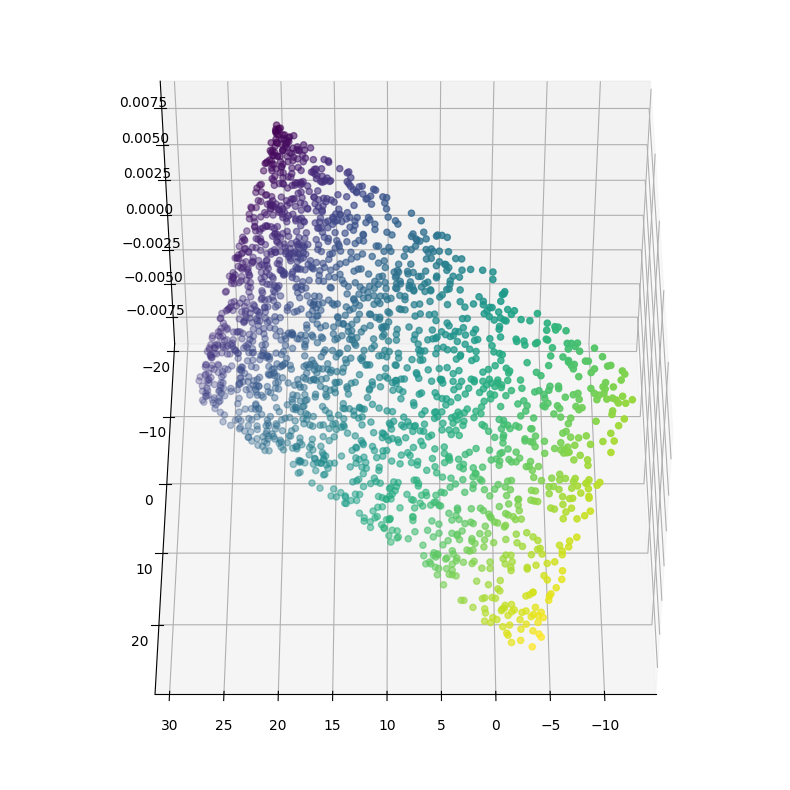

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_ms[:, 0], X_ms[:, 1], X_ms[:, 2], c=X_ms[:, 1])
ax.view_init(45, 90)

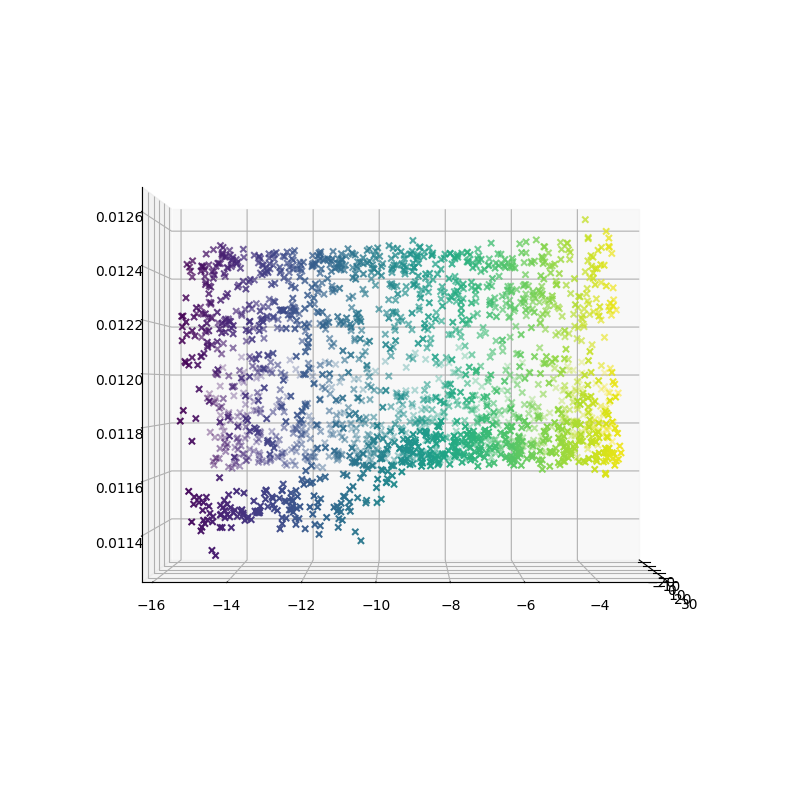

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_ms[:, 0], X_ms[:, 1], X_ms[:, 2], c=X_ms[:, 1])
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=X_pca[:, 1], marker='x')
ax.view_init(0, 0)

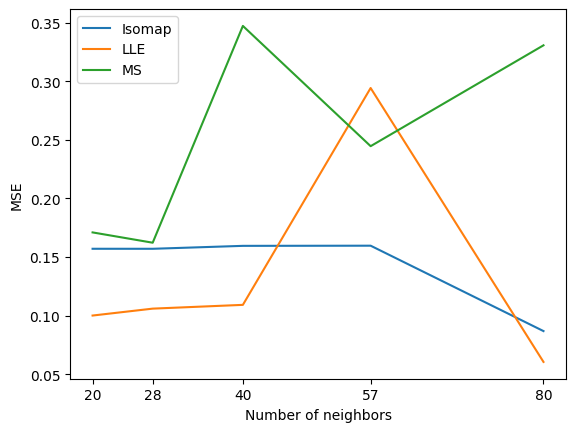

In [9]:
mse_isomap = np.zeros(len(isomap_files))
mse_lle = np.zeros(len(lle_files))
mse_ms = np.zeros(len(ms_files))

for i in range(len(isomap_files)):
    X_isomap = np.loadtxt(isomap_files[i])
    X_lle = np.loadtxt(lle_files[i])
    X_ms = np.loadtxt(ms_files[i])

    X_isomap_scal = minmax_scale(X_isomap)
    X_lle_scal = minmax_scale(X_lle)
    X_ms_scal = minmax_scale(X_ms)
    # X_ms_scal[:, 1] = X_ms_scal[:, 1][::-1]

    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    ax[0, 0].scatter(X_2D_scal[:, 0], X_2D_scal[:, 1])
    ax[0, 0].set_title('Theorethocal')

    ax[0, 1].scatter(X_isomap_scal[:, 0], X_isomap_scal[:, 1])
    ax[0, 1].set_title('Isomap')

    ax[1, 0].scatter(X_lle_scal[:, 0], X_lle_scal[:, 1])
    ax[1, 0].set_title('LLE')

    ax[1, 1].scatter(X_ms_scal[:, 1], X_ms_scal[:, 2])
    ax[1, 1].set_title('MS')

    plt.savefig(data_folder + 'fig_' + str(n_neighbors[i]) + '.png')
    plt.close()

    mse_isomap[i] = mean_squared_error(X_2D_scal, X_isomap_scal)
    mse_lle[i] = mean_squared_error(X_2D_scal, X_lle_scal)
    mse_ms[i] = mean_squared_error(X_2D_scal, X_ms_scal[:, 1:])

plt.plot(n_neighbors, mse_isomap, label='Isomap')
plt.plot(n_neighbors, mse_lle, label='LLE')
plt.plot(n_neighbors, mse_ms, label='MS')
plt.xticks(n_neighbors)
plt.xlabel('Number of neighbors')
plt.ylabel('MSE')
plt.legend()

## S Curve

In [37]:
data_folder = '../data/results_sCurve/k14/'

isomap_files = np.sort(glob.glob(data_folder + 'isomap_*.npy'))
lle_files = np.sort(glob.glob(data_folder + 'LLE_*.npy'))
ms_files = np.sort(glob.glob(data_folder + 'MS_*.npy'))

X_2D_files = np.sort(glob.glob('../data/sCurve2D/N_*.npy'))

sizes = [250, 500, 1000, 2000, 4000]

Text(0.5, 1.0, 'MS')

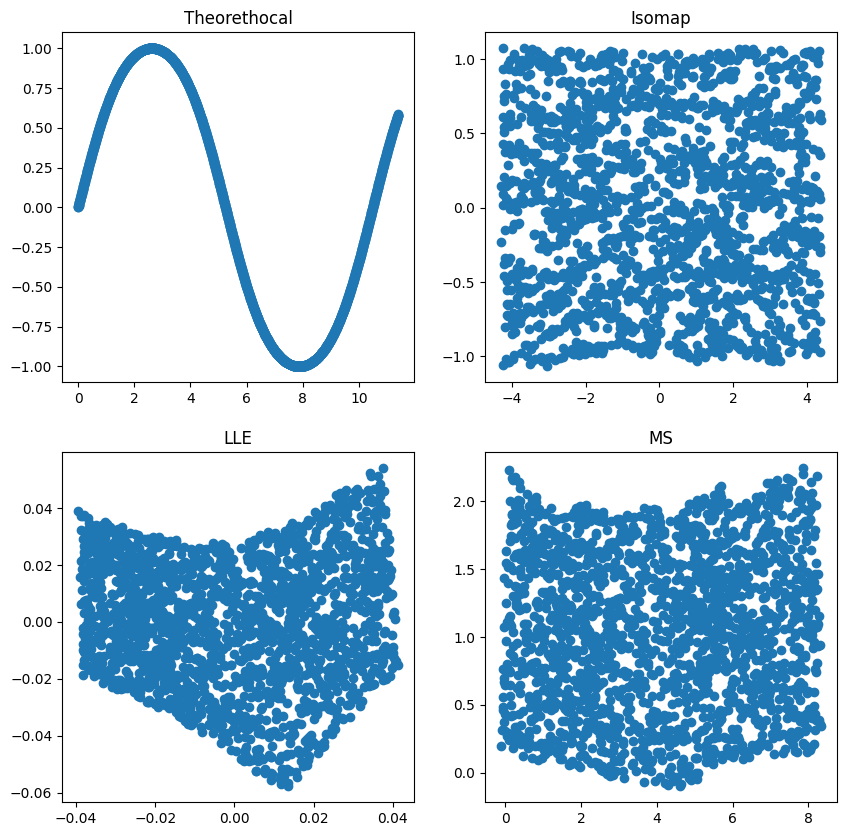

In [40]:
i = 1
X_2D = np.load(X_2D_files[i])
X_isomap = np.loadtxt(isomap_files[i])
X_lle = np.loadtxt(lle_files[i])
X_ms = np.loadtxt(ms_files[i])

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(X_2D[:, 0], X_2D[:, 1])
ax[0, 0].set_title('Theorethocal')

ax[0, 1].scatter(X_isomap[:, 0], X_isomap[:, 1])
ax[0, 1].set_title('Isomap')

ax[1, 0].scatter(X_lle[:, 0], X_lle[:, 1])
ax[1, 0].set_title('LLE')

ax[1, 1].scatter(X_ms[:, 0], X_ms[:, 1])
ax[1, 1].set_title('MS')